In [ ]:
import pandas as pd
import argparse
import numpy as np
import pickle

orig_file = "/gpfs/home/lc3424/capstone/2021_dementia/lc3424_workspace/experiments/20211102/volume_label_with_file_path_with_age_20211102.tsv"

orig_file_df = pd.read_csv(orig_file, sep='\t', index_col=0)
orig_file_df


In [ ]:
subjects = list(set(orig_file_df.Subject.to_list()))
len(subjects)

In [ ]:
subjects = np.random.RandomState(seed=42).permuation(subjects, random_state=1)

In [ ]:
train_subject = subjects[:int(len(subject) * .7)]
val_subject = subjects[int(len(subject) * .7): int(len(subject) * .85)]
test_subject = subjects[int(len(subject) * .85):]

In [ ]:
train_df = orig_file_df[orig_file_df.Subject.isin(train_subject)]
val_df = orig_file_df[orig_file_df.Subject.isin(val_subject)]
test_df = orig_file_df[orig_file_df.Subject.isin(test_subject)]

print('Train shape: {}, val shape: {}, test shape: {}'.format(tran_df.shape, val_df.shape, test_df.shape))


In [ ]:
orig_file_name = arguments.orig_file.split('.')[0]
train_df.to_csv(orig_file_name + 'train.tsv', sep='\t')
val_df.to_csv(orig_file_name + 'val.tsv', sep='\t')
test_df.to_csv(orig_file_name + 'test.tsv', sep='\t')

In [ ]:
import pandas as pd
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
from nilearn import image
import ants
from datetime import datetime, timedelta
import pydicom as dicom
import pickle
import matplotlib.image as mpimg
from collections import defaultdict, Counter
from scipy import stats

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [ ]:
f1 = '/gpfs/data/razavianlab/data/mri/nyu/barlow_bids_t1_preprocess_lin/subjects/sub-0a2b22da7f004536adef5ac670d443c2/ses-184837540961/t1_linear/sub-0a2b22da7f004536adef5ac670d443c2_ses-184837540961_20111111-SAG_MPR-2_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w.nii.gz'
f2 = '/gpfs/data/razavianlab/data/mri/nyu/barlow_bids_t1_preprocess_lin/subjects/sub-0a2b22da7f004536adef5ac670d443c2/ses-184837540961/t1_linear/sub-0a2b22da7f004536adef5ac670d443c2_ses-184837540961_20111111-SAG_MPR-2_T1w_space-MNI152NLin2009cSym_res-1x1x1_affine.mat'
f3 = '/gpfs/data/razavianlab/data/mri/nyu/barlow_bids_t1_preprocess_lin/subjects/sub-0a2b22da7f004536adef5ac670d443c2/ses-184837540961/t1_linear/sub-0a2b22da7f004536adef5ac670d443c2_ses-184837540961_20111111-SAG_MPR-2_T1w_space-MNI152NLin2009cSym_res-1x1x1_T1w.nii.gz'

In [ ]:
# cropped
file = nib.load(f1)
img = file.get_fdata()
plt.imshow(img[:,:,100], cmap='gray')
img.shape

In [ ]:
# not cropped

file = nib.load(f3)
img = file.get_fdata()
plt.imshow(img[:,:,100], cmap='gray')
img.shape

In [ ]:
import torch

In [ ]:
best_model_dir = '/gpfs/home/lc3424/capstone/2021_dementia/lc3424_workspace/experiments/20211102/saved_model/'
model_name = 'age_expansion_8'
pretrained_dict = torch.load(best_model_dir+model_name + '_model_low_loss.pth.tar',map_location='cpu')['state_dict']
pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if 'classifier.classifier.LinearClassifier' not in k}
pretrained_dict.keys()

In [ ]:
fc = ['classifier.classifier.LinearClassifier', 'classifier.classifier.LinearClassifier2']

In [ ]:
d = pickle.load(open('res.pkl', 'rb'))
d.keys()

In [ ]:
res = d['res']
out = d['out']

In [ ]:
label = np.argmax(out, axis=1)
label

In [ ]:
# res.drop('Unnamed: 0', axis=1, inplace=True)
res['label_pred'] = label
res[['score_0', 'score_1', 'score_2']] = out
# res.drop('Label', axis=1, inplace=True)
res

In [ ]:
res.label_pred.value_counts()

In [ ]:
res.to_csv('linear_crop_label_predict.tsv', index=False, sep='\t')

# Precision-recall Curve

In [1]:
import pandas as pd
import argparse
import numpy as np
import pickle
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-cdljzp9u because the default path (/gpfs/home/lc3424/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def pr_curve(file_name, c='AD'):
    def softmax(a, axis=None):
        """
        Computes exp(a)/sumexp(a); relies on scipy logsumexp implementation.
        :param a: ndarray/tensor
        :param axis: axis to sum over; default (None) sums over everything
        """
        from scipy.special import logsumexp
        lse = logsumexp(a, axis=axis)  # this reduces along axis
        if axis is not None:
            lse = np.expand_dims(lse, axis)  # restore that axis for subtraction
        return np.exp(a - lse)

    inp = pickle.load(open(file_name, 'rb'))
    # inp['out'] = softmax(inp['out'], axis=1)
    df2 = pd.concat([inp['res'], pd.DataFrame(inp['out'], columns=['CN', 'MCI', 'AD'])], axis=1)
    c_num = 0
    if c == 'AD':
        c_num = 2
    elif c == 'MCI':
        c_num = 1
    elif c == 'CN':
        c_num = 0
    else:
        raise Exception('exception')

    p, r, _ = precision_recall_curve((df2.Label.to_numpy() == c_num).astype(int), df2[c].to_numpy())
    plt.plot(r, p, lw=2, label=c)

def pr_curve_aggregate(file_name):
    for c in ['CN', 'MCI', 'AD']:
        pr_curve(file_name, c)
    plt.legend(loc="best")
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.title("Precision-recall curve for {}".format(" ".join(file_name.split('/')[-1].split('.')[0].split('_')[1:])))
    plt.savefig("figures/precision_recall_curve_{}.png".format("_".join(file_name.split('/')[-1].split('.')[0].split('_')[1:])), facecolor='white')
    plt.show()

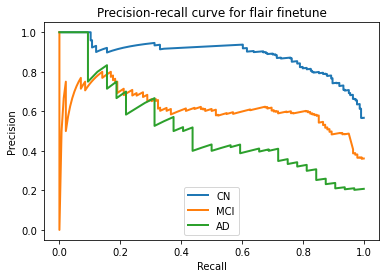

In [3]:
file_name = '/gpfs/home/lc3424/capstone/2021_dementia/lc3424_workspace/experiments/20211102/res_flair_finetune.pkl'
pr_curve_aggregate(file_name)

In [7]:
inp = pickle.load(open(file_name, 'rb'))
# inp['out'] = softmax(inp['out'], axis=1)
df2 = pd.concat([inp['res'], pd.DataFrame(inp['out'], columns=['CN', 'MCI', 'AD'])], axis=1)
df2

,Session,Subject,Label,Age,Path,CN,MCI,AD
0,100705385639,4c1833793b70449da1017a8eb7592b12,2,77,/gpfs/data/razavianlab/data/mri/nyu/barlow_bid...,-1.470156,1.710143,-0.502922
1,100705385639,4c1833793b70449da1017a8eb7592b12,2,77,/gpfs/data/razavianlab/data/mri/nyu/barlow_bid...,-1.463283,1.706425,-0.505954
2,102180780180,20d22e8c23a942b8aec67e25c4fbe848,1,63,/gpfs/data/razavianlab/data/mri/nyu/barlow_bid...,-1.041704,1.407455,-0.588134
3,102180780180,20d22e8c23a942b8aec67e25c4fbe848,1,63,/gpfs/data/razavianlab/data/mri/nyu/barlow_bid...,-1.245616,1.379458,-0.320191
4,102303089179,20d22e8c23a942b8aec67e25c4fbe848,1,63,/gpfs/data/razavianlab/data/mri/nyu/barlow_bid...,-1.112956,1.389312,-0.483779
...,...,...,...,...,...,...,...,...
476,992233082673,82698a601fdb430f88b412b401aa12b5,0,56,/gpfs/data/razavianlab/data/mri/nyu/barlow_bid...,1.426278,-0.232635,-1.292418
477,992233082673,82698a601fdb430f88b412b401aa12b5,0,56,/gpfs/data/razavianlab/data/mri/nyu/barlow_bid...,1.268008,-0.144171,-1.192954
478,992384850744,9d24c408174946f690f9bcabadfadf6e,0,75,/gpfs/data/razavianlab/data/mri/nyu/barlow_bid...,1.397451,0.216924,-1.740484
479,992384850744,9d24c408174946f690f9bcabadfadf6e,0,75,/gpfs/data/razavianlab/data/mri/nyu/barlow_bid...,1.500988,0.204986,-1.827755


In [8]:
df2.Label.value_counts()

1    233
0    205
2     43
Name: Label, dtype: int64

In [1]:
import pandas as pd

df = pd.read_csv('/gpfs/home/lc3424/capstone/2021_dementia/lc3424_workspace/experiments/20211102/t1_flair_file_match_with_reg.tsv', sep='\t')
df.Label = df.Label.astype(int)
df
df.to_csv('/gpfs/home/lc3424/capstone/2021_dementia/lc3424_workspace/experiments/20211102/t1_flair_file_match_with_reg.tsv', index=False, sep='\t')

In [4]:
df = pd.read_csv('/gpfs/home/lc3424/capstone/2021_dementia/lc3424_workspace/experiments/20211102/t1_flair_file_match_with_reg_test.tsv', sep='\t')
df.Label.value_counts()

0    224
1    142
2     32
Name: Label, dtype: int64

In [43]:
import pandas as pd
import argparse
import numpy as np
import pickle

t1_path_label_file = '/gpfs/home/lc3424/capstone/2021_dementia/lc3424_workspace/experiments/20211102/label_and_file_path/20211206/t1_train.tsv'
flair_path_label_file = '/gpfs/home/lc3424/capstone/2021_dementia/lc3424_workspace/experiments/20211102/label_and_file_path/20211206/flair_train.tsv'
t1_subject_tsv = pd.read_csv(t1_path_label_file, sep='\t').loc[:, ['Session', 'Label', 'Subject', 'Age', 'Path']]
t1_subject_tsv.rename({'Path' : 't1_path'}, axis=1, inplace=True)
flair_subject_tsv = pd.read_csv(flair_path_label_file, sep='\t').loc[:, ['Session', 'Path']]
flair_subject_tsv.rename({'Path' : 'flair_path'}, axis=1, inplace=True)
print(t1_subject_tsv.shape, flair_subject_tsv.shape)
subject_tsv = t1_subject_tsv.merge(flair_subject_tsv, how='left', on=['Session'])
ssubject_tsv = ubject_tsv[~subject_tsv.isna().any(axis=1)].drop_duplicates()

(2306, 5) (2050, 2)


In [44]:
subject_tsv
subject_tsv[subject_tsv.isna().any(axis=1)]

,Session,Label,Subject,Age,t1_path,flair_path
101,105420328012,0,3a5efc4cfd3443eeb185797148fc36d9,68,/gpfs/data/razavianlab/data/mri/nyu/barlow_bid...,NaN
102,105420328012,0,3a5efc4cfd3443eeb185797148fc36d9,68,/gpfs/data/razavianlab/data/mri/nyu/barlow_bid...,NaN
150,111521726612,0,4c2376d23576483ba1510608923d23a7,68,/gpfs/data/razavianlab/data/mri/nyu/barlow_bid...,NaN
157,112323879663,0,75acb785672d409e800782126cd12a6a,66,/gpfs/data/razavianlab/data/mri/nyu/barlow_bid...,NaN
158,112323879663,0,75acb785672d409e800782126cd12a6a,66,/gpfs/data/razavianlab/data/mri/nyu/barlow_bid...,NaN
...,...,...,...,...,...,...
3992,848694441792,0,6ae419eccbd14639beaae164e64a3444,78,/gpfs/data/razavianlab/data/mri/nyu/barlow_bid...,NaN
3997,851909025503,0,ed07725f54f64028867b43681e515dcf,58,/gpfs/data/razavianlab/data/mri/nyu/barlow_bid...,NaN
3998,851909025503,0,ed07725f54f64028867b43681e515dcf,58,/gpfs/data/razavianlab/data/mri/nyu/barlow_bid...,NaN
4095,908598147225,0,12191bb2a3a94f5ea8447856800f3257,84,/gpfs/data/razavianlab/data/mri/nyu/barlow_bid...,NaN


,Session,Label,Subject,Age,t1_path,flair_path
0,100039817943,0,210909b9725245c5a09e052b931447f4,52,/gpfs/data/razavianlab/data/mri/nyu/barlow_bid...,/gpfs/data/razavianlab/data/mri/nyu/barlow_fla...
1,100039817943,0,210909b9725245c5a09e052b931447f4,52,/gpfs/data/razavianlab/data/mri/nyu/barlow_bid...,/gpfs/data/razavianlab/data/mri/nyu/barlow_fla...
2,100402864124,0,fc9d3132547b40d88b14b49f22059a7d,58,/gpfs/data/razavianlab/data/mri/nyu/barlow_bid...,/gpfs/data/razavianlab/data/mri/nyu/barlow_fla...
3,100402864124,0,fc9d3132547b40d88b14b49f22059a7d,58,/gpfs/data/razavianlab/data/mri/nyu/barlow_bid...,/gpfs/data/razavianlab/data/mri/nyu/barlow_fla...
4,100705385639,2,4c1833793b70449da1017a8eb7592b12,77,/gpfs/data/razavianlab/data/mri/nyu/barlow_bid...,/gpfs/data/razavianlab/data/mri/nyu/barlow_fla...
...,...,...,...,...,...,...
4191,998819920173,1,bbc73dd2480442108e5307511a1b9b75,54,/gpfs/data/razavianlab/data/mri/nyu/barlow_bid...,/gpfs/data/razavianlab/data/mri/nyu/barlow_fla...
4192,998819920173,1,bbc73dd2480442108e5307511a1b9b75,54,/gpfs/data/razavianlab/data/mri/nyu/barlow_bid...,/gpfs/data/razavianlab/data/mri/nyu/barlow_fla...
4193,998819920173,1,bbc73dd2480442108e5307511a1b9b75,54,/gpfs/data/razavianlab/data/mri/nyu/barlow_bid...,/gpfs/data/razavianlab/data/mri/nyu/barlow_fla...
4194,999155686841,0,b3ddd61266c842a9b98597579f1054df,56,/gpfs/data/razavianlab/data/mri/nyu/barlow_bid...,/gpfs/data/razavianlab/data/mri/nyu/barlow_fla...


In [50]:
subject_tsv.iloc[0, -1]

'/gpfs/data/razavianlab/data/mri/nyu/barlow_flair_registered/2097337647-20120107-AX_FLAIR-5_flair_reg.nii.gz'

In [51]:
subject_tsv.iloc[1, -1]

'/gpfs/data/razavianlab/data/mri/nyu/barlow_flair_registered/2097337647-20120107-AX_FLAIR-5a_flair_reg.nii.gz'